In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
compiled_fixations_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/compiled_fixations.csv'
participant_info_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/participant_info.csv'

compiled_fixations_df = pd.read_csv(compiled_fixations_url)
participant_info_df = pd.read_csv(participant_info_url)

merged_df = pd.merge(compiled_fixations_df, participant_info_df, on='ID')

# replace date of birth with age
merged_df['age'] = 2023 - merged_df['DoB']

# leaving only valid viewers
merged_df = merged_df[(merged_df['Valid'] == True) & (merged_df['Valid Freeviewing'] == True)]

# drop irrelevant columns
df = merged_df[['ID', 'Gender', 'age', 'Order', 'duration', 'onset']]

# convert column names to lowercase
df.columns = df.columns.str.lower()

# dropping default year 2000 from dataset
df = df[(df['age'] != 23)]

In [14]:
df.to_csv('main_df.csv')

In [71]:
grouped_df = df.groupby('age').agg({'duration': 'mean'}).reset_index()
grouped_df['duration'] = grouped_df['duration'] * 1000
# grouped_df = grouped_df[grouped_df['age'] < 70]

In [70]:
df[df['age'] > 70]['id'].unique()

array([20230316140854494, 20230317141106337, 20230422140426041,
       20230423114119235, 20230521132626116, 20230603145649746,
       20230616112052895, 20230626145438666, 20230716130511172,
       20230717150558263, 20230720141707563, 20230722093924134,
       20230805150550359, 20230814144928989, 20230822142220180,
       20230905120942781, 20230915120248635, 20231016143041604,
       20231026103330599, 20231030153134529, 20231111134450781,
       20231114142509536])

In [8]:
grouped_df['order'].median() - 2*grouped_df['order'].std()

np.float64(16.070070451202383)

In [9]:
grouped_df['order'].median() + 2*grouped_df['order'].std()

np.float64(33.92992954879762)

In [10]:
filtered_grouped_df = grouped_df[(grouped_df['order'] >= 16) & (grouped_df['order'] <= 34)]

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                   76
Model:                            GLM   Df Residuals:                       73
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1127.9
Method:                          IRLS   Log-Likelihood:                -373.38
Date:                Thu, 21 Nov 2024   Deviance:                       82336.
Time:                        16:46:26   Pearson chi2:                 8.23e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1395
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     285.7670     13.121     21.780      

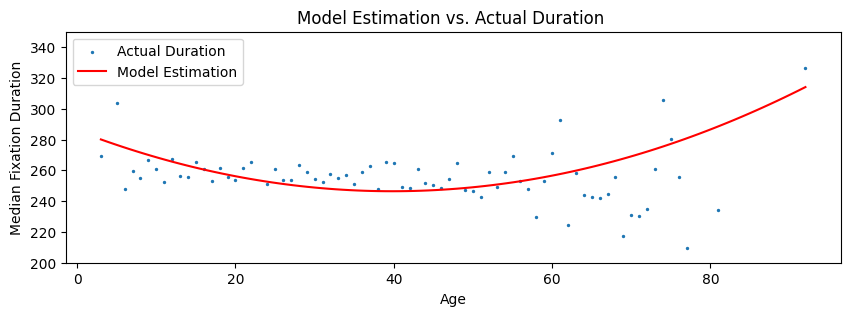

In [72]:
import statsmodels.formula.api as sm
import statsmodels.api as sma



# Fit a GLM with age and age_squared as covariates
model = sm.glm('duration ~ age + I(age**2) ', data=grouped_df).fit()

# Print the model summary
print(model.summary())

residuals = model.resid_deviance  # Deviance residuals are often used for GLM
#sma.qqplot(residuals, line='45')
#plt.title('QQ Plot of Residuals')
#plt.show()
plot_model(model, grouped_df, "")

In [47]:
def plot_model(mod, data, caption):
    age_range = np.linspace(data['age'].min(), data['age'].max(), 100)

    # Predict durations for the age range using the fitted model
    predicted_durations = mod.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))

    # Plot the actual durations and the model estimations
    plt.figure(figsize=(10, 3))
    plt.scatter(data['age'], data['duration'], label='Actual Duration', s=2)
    plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
    plt.ylim((200, 350))
    plt.xlabel('Age')
    plt.ylabel('Median Fixation Duration')
    plt.title(f'Model Estimation vs. Actual Duration {caption}')
    plt.legend()
    plt.show()

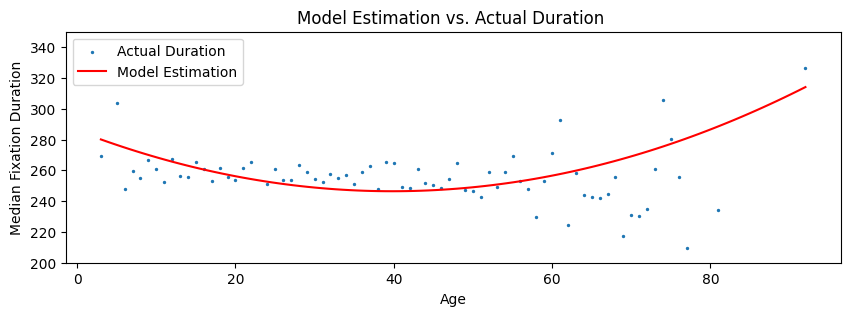

In [54]:
plot_model(model, grouped_df, "")

In [115]:
df['onset_bin'] = pd.cut(df['onset'], bins=50)

# Group by the bins and calculate the median duration for each group
median_durations = df.groupby('onset_bin')['duration'].mean()

# Reset the index for a cleaner output
median_durations = median_durations.reset_index()

median_durations['right'] = median_durations['onset_bin'].apply(lambda interval: interval.right)



C:\Users\Пользователь\AppData\Local\Temp\ipykernel_8660\2140541048.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_durations = df.groupby('onset_bin')['duration'].mean()


In [91]:
median_durations

np.float64(0.207)

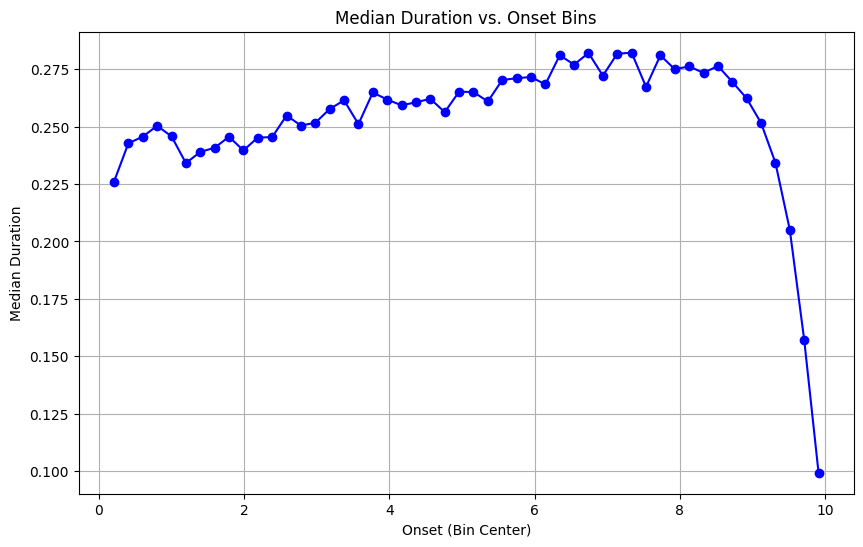

In [100]:

plt.figure(figsize=(10, 6))
plt.plot(median_durations['right'], median_durations['duration'], marker='o', linestyle='-', color='b')
plt.title("Median Duration vs. Onset Bins")
plt.xlabel("Onset (Bin Center)")
plt.ylabel("Median Duration")
plt.grid(True)
plt.show()

In [116]:
median_durations['right'] = median_durations['right'].astype(str).astype(float)

# median_durations = median_durations[median_durations['right']<8]

model_bins = sm.glm('duration ~ right + I(right**2)', data=median_durations).fit()

# Print the model summary
print(model_bins.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      0.00059828
Method:                          IRLS   Log-Likelihood:                 116.14
Date:                Thu, 21 Nov 2024   Deviance:                     0.028119
Time:                        17:20:35   Pearson chi2:                   0.0281
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4698
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2094      0.011     19.309

In [129]:
model_bins.params

Intercept        0.209424
right            0.026432
I(right ** 2)   -0.002659
dtype: float64

--------------------------------

In [31]:
df_female = df[df["gender"]=="FEMALE"]

In [28]:
df_male = df[df["gender"]=="MALE"]

In [20]:
import math

In [31]:
df_female["duration"] = df_female["duration"] * 1000
df_female["duration"] = df_female["duration"].apply(math.log)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_12672\652272052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female["duration"] = df_female["duration"] * 1000
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_12672\652272052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female["duration"] = df_female["duration"].apply(math.log)


In [32]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

grouped_df = df_female.groupby('id').agg({'duration': 'median', 'age': 'first'})

more_grouped_df = grouped_df.groupby('age').agg(
    duration=('duration', 'mean'),  # Mean of target
    count_target=('duration', 'count')  # Count of target values
).reset_index()


more_grouped_df["const"] = 1
more_grouped_df["age_squared"] = more_grouped_df["age"]**2
more_grouped_df = more_grouped_df[more_grouped_df['age'] > 22]

X = more_grouped_df[['const', 'age', 'age_squared']]
Y = more_grouped_df["duration"]
groups = more_grouped_df['age']
# Fit a GLM with age and age_squared as covariates
# model = sma.GEE('duration ~ age + I(age**2)', data=grouped_df, family=sma.families.InverseGaussian()).fit()

model = sma.GEE(endog=Y, exog=X, groups=groups, family=sma.families.InverseGaussian()).fit()

# Print the model summary
print(model.summary())
'''
residuals = model.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()
'''

                               GEE Regression Results                              
Dep. Variable:                    duration   No. Observations:                   51
Model:                                 GEE   No. clusters:                       51
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   1
Family:                    InverseGaussian   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     1
Date:                     Mon, 18 Nov 2024   Scale:                           0.051
Covariance type:                    robust   Time:                         18:26:49
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          23.9831      4.000      5.996      0.000      16.144      31.822
age 

"\nresiduals = model.resid_deviance  # Deviance residuals are often used for GLM\nsma.qqplot(residuals, line='45')\nplt.title('QQ Plot of Residuals')\nplt.show()\n"

In [69]:
more_grouped_df = grouped_df.groupby('age').agg(
    mean_target=('duration', 'mean'),  # Mean of target
    count_target=('duration', 'count')  # Count of target values
).reset_index()

In [67]:
grouped_df.head(2)

,duration,age,const,age_squared
id,,,,
20230314115611868,0.197,25,1,625
20230314120855847,0.167,40,1,1600


------------------------------

In [58]:
# drop irrelevant columns
df_spot = merged_df[['ID', 'Gender', 'age', 'Order', 'duration', 'avg_x', 'avg_y']]
# convert column names to lowercase
df_spot.columns = df_spot.columns.str.lower()
# dropping default year 2000 from dataset
df_spot = df_spot[df_spot['age'] != 23]

df_spot_man = df_spot[(df_spot['avg_x']>1000) & (df_spot['avg_x']<1500) & (df_spot['avg_y']>600) & (df_spot['avg_y']<1100)  ]
df_spot_woman = df_spot[(df_spot['avg_x']>660) & (df_spot['avg_x']<1000) & (df_spot['avg_y']>600) & (df_spot['avg_y']<1100)  ]

In [41]:
# function for plotting the fitted model vs actual data
def plot_model(mod, data, caption):
    age_range = np.linspace(data['age'].min(), data['age'].max(), 100)

    # Predict durations for the age range using the fitted model
    predicted_durations = mod.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))

    # Plot the actual durations and the model estimations
    plt.figure(figsize=(10, 3))
    plt.scatter(data['age'], data['duration'], label='Actual Duration', s=2)
    plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
    plt.ylim((0.1, 0.5))
    plt.xlabel('Age')
    plt.ylabel('Median Fixation Duration')
    plt.title(f'Model Estimation vs. Actual Duration {caption}')
    plt.legend()
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4381
Model:                            GLM   Df Residuals:                     4379
Model Family:         InverseGaussian   Df Model:                            1
Link Function:                    Log   Scale:                          1.1805
Method:                          IRLS   Log-Likelihood:                 3749.8
Date:                Mon, 18 Nov 2024   Deviance:                       3676.9
Time:                        18:59:10   Pearson chi2:                 5.17e+03
No. Iterations:                     9   Pseudo R-squ. (CS):           0.001184
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3482      0.013   -105.549      

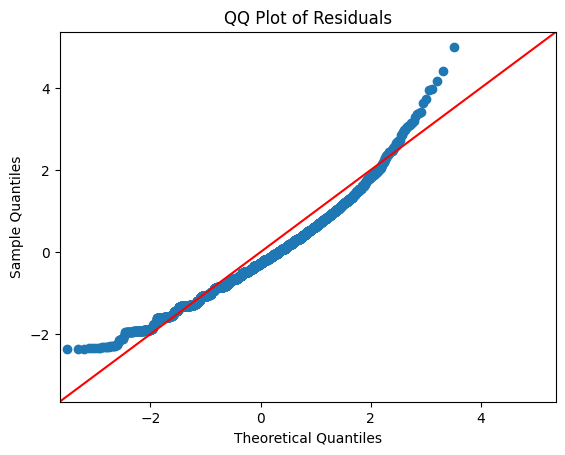

In [61]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

df_spot_man_grouped = df_spot_man.groupby('id').agg({'duration': 'median', 'age': 'first'})

# Fit a GLM with age_squared as covariate
model = sm.glm('duration ~ I(age**2)', data=df_spot_man_grouped, family=sma.families.InverseGaussian(link=sma.families.links.Log())).fit()

# Print the model summary
print(model.summary())

residuals = model.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

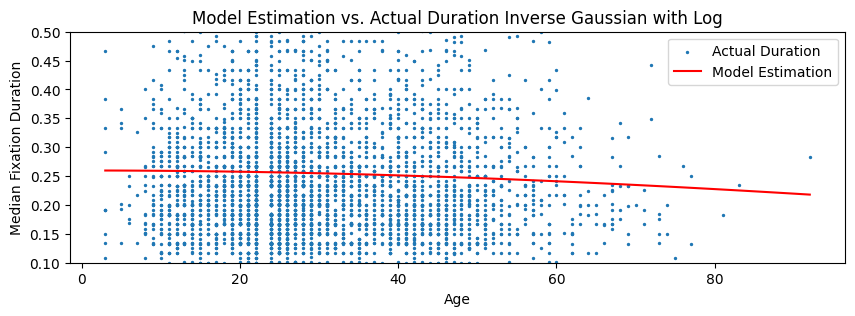

In [62]:
plot_model(model, df_spot_man_grouped, "Inverse Gaussian with Log")



In [117]:
models = df

In [124]:
float(model.params[1])

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_8660\97939242.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  float(model.params[1])


-1.9766738614647161

In [ ]:
models['coef'] = models['duration']

In [125]:
df['total'] = df['onset'] + df['duration']

посмотреть, что там с хвостом, как он отрубается.

In [142]:
from task_1 import duration_vs_age
res = duration_vs_age(compiled_fixations_url, participant_info_url)

In [132]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                   76
Model:                            GLM   Df Residuals:                       73
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1127.9
Method:                          IRLS   Log-Likelihood:                -373.38
Date:                Fri, 22 Nov 2024   Deviance:                       82336.
Time:                        12:03:51   Pearson chi2:                 8.23e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1395
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     285.7670     13.121     21.780      

In [3]:
from task_2 import duration_vs_onset
res = duration_vs_onset(compiled_fixations_url, participant_info_url)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      3.4104e-05
Method:                          IRLS   Log-Likelihood:                 187.75
Date:                Fri, 22 Nov 2024   Deviance:                    0.0016029
Time:                        12:19:48   Pearson chi2:                  0.00160
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9947
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2341      0.003     90.341